# ANALYSIS OF U.S. STOCK MARKET FLUCTUATION IN 2020

## Financial and Accounting Analysis of the Stock Market Plunge and Recovery in 2020 During Covid-19 Pandemic

* A financial/accounting analysis of a large set of U.S. companies affected by the stock market shocks in 2020.

* A predictive analytics exercise to explain what types of companies did the best/worst during the **initial COVID shock (January-March 2020)**.

* A predictive analytics exercise to explain what types of companies did the best/worst during the **market recovery (April-December 2020)**.

# Environment Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
root_dir = "/content/gdrive/MyDrive/Colab Notebooks/"
project_folder = "BA870 Finance/Project"
# change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)
# print current working directory
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/BA870 Finance/Project'

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 29.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.60-py2.py3-none-any.whl size=23819 sha256=b362b48df2161a83be73039b31ad3f77efa9083a1837bd42fece406b1c17fa1b
  Stored in directory: /root/.cache/pip/wheels/f0/be/a4/846f02c5985562250917b0ab7b33fff737c8e6e8cd5209aa3b
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
!pip install transformers

     |████████████████████████████████| 2.5MB 25.6MB/s 
     |████████████████████████████████| 901kB 28.9MB/s 
     |████████████████████████████████| 3.3MB 30.6MB/s 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import torch
import transformers as ppb
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing Stock Data

## Monthly Returns of Stocks and S&P 500 in 2020

`monthlystock.csv` contains the stock data for all the U.S. companies in WRDS CRSP database.
* `PERMCO` is the unique identifier of a company in CRSP.
* `date` is the date of the last trading day of each month in 2020.
* `ticker` is the ticker for each stock.
* `price` is the closing price on the last trading day in each month in 2020.
* `ret` is the holding period (monthly) return for each stock.

In [6]:
stock = pd.read_csv('monthlystock.csv')

In [7]:
# clean up the columns
stock.rename(columns={'TICKER': 'ticker', 'PRC': 'price', 'RET': 'ret'}, inplace=True)
stock.date = pd.to_datetime(stock.date, format="%Y%m%d")
stock['month'] = pd.DatetimeIndex(stock.date).month

Use the data from Yahoo Finance to calculate the monthly return on S&P 500 in 2020.

In [8]:
# extract S&P 500 prices from Yahoo Finance
df_yahoo = yf.download('^GSPC', start="2019-12-31", end="2021-01-01", group_by='ticker')
dates = ['2019-12-31']
dates.extend(list(stock.date.astype(str).unique()))
prices = round(df_yahoo.loc[dates, 'Close'], 2).to_list()

[*********************100%***********************]  1 of 1 completed


In [9]:
# calculate monthly returns in 2020
returns = []

for i, v in enumerate(prices[1:]):
    this = v
    last = prices[i]
    ret = round((this-last)/last, 6)
    returns.append(ret)

sp = pd.DataFrame({'month': [i for i in range(1, 13)], 'SPret': returns})
sp.head(1)

,month,SPret
0,1,-0.001628


Store the monthly returns on S&P 500 under `SPret` in the dataframe.

In [10]:
stock = stock.merge(sp, on='month', how='left')

In [11]:
# drop observations with missing values in ticker or monthly return
stock.dropna(subset=['ticker', 'ret'], inplace=True)
stock.reset_index(drop=True, inplace=True)

There are 1457 companies that do not have valid returns for all 12 months.

In [12]:
tmp = stock.ticker.value_counts()
tmp.lt(12).sum()

1457

In [13]:
# remove 1457 observations
print("Number of unique tickers:", stock.ticker.nunique())
stock = stock[stock.ticker.isin(tmp.index[tmp.lt(12)])==False]
print("Number of unique tickers:", stock.ticker.nunique())

Number of unique tickers: 8399
Number of unique tickers: 6942


There are 19 companies that have two sets (24) of monthly returns.


In [14]:
tmp = stock.ticker.value_counts()
tmp.value_counts()

12    6923
24      19
Name: ticker, dtype: int64

Cross examine two sets of stock prices from CRSP with those listed on Yahoo Finance and only keep the ones that match.

In [15]:
tics = " ".join(tmp.index[tmp.gt(12)].to_list())
df_yahoo = yf.download(tics, start="2019-12-31", end="2021-01-01", group_by='ticker')
dates = ['2020-01-31', '2020-02-28', '2020-03-31', '2020-04-30', '2020-05-29', '2020-06-30', 
         '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-30', '2020-11-30', '2020-12-31']

for i in tmp.index[tmp.gt(12)]:
    if df_yahoo[i].dropna().empty:
        continue
    else:
        try:
            prices = round(df_yahoo[i].loc[dates, 'Close'], 2).to_list()
            stock.loc[stock.ticker==i, 'price'] = stock[stock.ticker==i]['price'].apply(lambda x: x if round(x, 2) in prices else np.nan)
            stock.dropna(subset=['price'], inplace=True)
        except:
            pass

[*********************100%***********************]  19 of 19 completed

7 Failed downloads:
- BF: No data found for this date range, symbol may be delisted
- CRD: No data found for this date range, symbol may be delisted
- LGF: No data found for this date range, symbol may be delisted
- JW: No data found for this date range, symbol may be delisted
- RDS: No data found for this date range, symbol may be delisted
- BRK: No data found for this date range, symbol may be delisted
- AKO: No data found for this date range, symbol may be delisted


There are still 7 companies with two sets of monthly data because their stock data cannot be found on Yahoo Finance. These companies will be dropped later when we merge the stock data with the accounting data.

In [16]:
tmp = stock.ticker.value_counts()
tmp.value_counts()

12    6935
24       7
Name: ticker, dtype: int64

## Market Betas in 2019

`betas19.csv` contains the market beta for all the U.S. companies in WRDS CRSP database.
* `PERMCO` is the unique identifier of a company in CRSP.
* `beta19` is the market beta of a stock in 2019.


In [17]:
betas = pd.read_csv('betas19.csv')

In [18]:
# clean up the dataframe
betas.rename(columns={'betav': 'beta19'}, inplace=True)
betas.head(1)

,PERMNO,beta19
0,10028,0.24393


In [19]:
# drop duplicated observations
betas.drop_duplicates(inplace=True)
betas.reset_index(drop=True, inplace=True)

There are 25 observations with two betas.

In [20]:
tmp = betas.PERMNO.value_counts()
tmp.value_counts()

1    6097
2      25
Name: PERMNO, dtype: int64

After examining the betas of these 25 observations, we found that all the duplicated betas are equal to 0. Drop these 25 zero betas and keep the 25 non-zeros betas.

In [21]:
betas[(betas.PERMNO.isin(tmp.index[tmp.gt(1)])) & (betas.beta19==0)].shape

(25, 2)

In [22]:
# drop 25 zero betas
tmp = betas[(betas.PERMNO.isin(tmp.index[tmp.gt(1)])) & (betas.beta19==0)].index
betas = betas[~betas.index.isin(tmp)]

In [23]:
# merge the dataframes
stock = stock.merge(betas, on='PERMNO', how='left')

In [24]:
stock = stock[['month', 'ticker', 'ret', 'SPret', 'beta19']].reset_index(drop=True)
print("Number of unique tickers:", stock.ticker.nunique())
stock.head(2)

Number of unique tickers: 6942


,month,ticker,ret,SPret,beta19
0,1,JJSF,-0.100016,-0.001628,0.01282
1,2,JJSF,-0.030270,-0.084110,0.01282


# Preprocessing Accounting Data

Import data about all the U.S. companies in WRDS Compustat database.
* `des` contains the descriptions of 2852 companies in the Russell 3000 Index scraped from Yahoo Finance.
* `wrds` contains the company financial data downloaded from Compustat (Fiscal Year 2018 and 2019).

In [25]:
des = pd.read_csv('2-3 stock_des.csv')
wrds = pd.read_csv('compustat1819.csv')

In [26]:
# keep 4379 companies that have stock data from CRSP
print('Number of unique tickers:', wrds.tic.nunique())
wrds = wrds[wrds.tic.isin(stock.ticker.unique())]
print('Number of unique tickers:', wrds.tic.nunique())

Number of unique tickers: 8209
Number of unique tickers: 4379


In [27]:
# keep 4348 companies that have accounting data from 2018 and 2019
wrds = wrds.groupby('tic').filter(lambda x: x['fyear'].count() == 2)
print('Number of unique tickers:', wrds.tic.nunique())

Number of unique tickers: 4348


In [28]:
# clean up the columns
wrds.rename(columns={'tic': 'ticker'}, inplace=True)
wrds.fyear = wrds.fyear.astype(str)
wrds[['gsector', 'ggroup', 'gind', 'gsubind']] = wrds[['gsector', 'ggroup', 'gind', 'gsubind']].astype(int)

In [29]:
# merge the dataframes
df = wrds.merge(des, on='ticker', how='left')

In [30]:
# organize the dataframe
df = df.set_index(['ticker', 'gsector', 'ggroup', 'gind', 'gsubind', 'naics', 'sic', 'spcsrc', 'description', 'fyear']).unstack()
# label the year in column names
df.columns = [col[0]+col[1][2:] for col in df.columns]
df.reset_index(inplace=True)
df.head(1)

,ticker,gsector,ggroup,gind,gsubind,naics,sic,spcsrc,description,at18,at19,act18,act19,invt18,invt19,lt18,lt19,lct18,lct19,ap18,ap19,teq18,teq19,re18,re19,sale18,sale19,cogs18,cogs19,xopr18,xopr19,ni18,ni19,oancf18,oancf19,ivncf18,ivncf19,fincf18,fincf19
0,A,35,3520,352030,35203010,334516.0,3826.0,B,"Agilent Technologies, Inc. provides applicatio...",8541.0,9452.0,3848.0,3189.0,638.0,679.0,3970.0,4704.0,1171.0,2080.0,340.0,354.0,4571.0,4748.0,-744.0,-532.0,4914.0,5163.0,2036.0,2140.0,3713.0,3889.0,316.0,1071.0,1087.0,1021.0,-704.0,-1590.0,-797.0,-299.0


## Organizing GICS Classification
The GICS structure consists of 11 sectors, 24 industry groups, 69 industries.

In [31]:
# scrape GICS classification from Wikipedia
wikiurl="https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard#Classification[1]"
response=requests.get(wikiurl)
print(response.status_code)

200


In [32]:
soup = BeautifulSoup(response.text, 'html.parser')
indiatable = soup.find('table', {'class':"wikitable"})
wiki = pd.read_html(str(indiatable))
wiki = pd.DataFrame(wiki[0])
wiki.head(1)

,Sector,Sector.1,Industry Group,Industry Group.1,Industry,Industry.1,Sub-Industry,Sub-Industry.1
0,10,Energy,1010,Energy,101010,Energy Equipment & Services,10101010,Oil & Gas Drilling


Create a GICS sector dictionary `gsectors` where `{"sector ID": "sector name"}`.

In [33]:
sectorID = wiki['Sector'].unique().tolist()
sector = wiki['Sector.1'].unique().tolist()
gsectors = {sectorID[i]: sector[i] for i in range(len(sectorID))}

Create a GICS group dictionary `ggroups` where `{"group ID": "group name"}`.

In [34]:
groupID = wiki['Industry Group'].unique().tolist()
group = wiki['Industry Group.1'].unique().tolist()
ggroups = {groupID[i]: group[i] for i in range(len(groupID))}

Create a GICS industry dictionary `ginds` where `{"industry ID": "industry name"}`.

In [35]:
indID = wiki['Industry'].unique().tolist()
industry = wiki['Industry.1'].unique().tolist()
ginds = {indID[i]: industry[i] for i in range(len(indID))}

Replace `gsector`, `ggroup` and `gind` IDs with sector names, group names and industry names.

In [36]:
df.gsector = df.gsector.apply(lambda x: gsectors[x])
df.ggroup = df.ggroup.apply(lambda x: ggroups[x])
df.gind = df.gind.apply(lambda x: ginds[x])

## Organizing NAICS Classification Code
The NAICS codes can be grouped into 20 sectors using the first two digits.

In [37]:
# scrape SIC classification from Wikipedia
import requests
from bs4 import BeautifulSoup

wikiurl="https://en.wikipedia.org/wiki/North_American_Industry_Classification_System#Codes"
response=requests.get(wikiurl)
print(response.status_code)

200


In [38]:
soup = BeautifulSoup(response.text, 'html.parser')
indiatable = soup.find_all('table', {'class':"wikitable"})
wiki = pd.read_html(str(indiatable))
wiki = pd.DataFrame(wiki[2])
print(wiki.shape)
wiki.head(1)

(20, 3)


,Sector #,Description,Note
0,11,"Agriculture, Forestry, Fishing and Hunting",NaN


Create a NAICS sector dictionary `nsectors` where `{"nsector ID": "nsector name"}`.

In [39]:
wiki['Sector #'] = wiki['Sector #'].apply(lambda x: x[:2])
wiki['Sector #'] = wiki['Sector #'].astype(int)

In [40]:
nsectorID = wiki['Sector #'].unique().tolist()
nsector = wiki['Description'].unique().tolist()
nsectors = {nsectorID[i]: nsector[i] for i in range(len(nsectorID))}

Create a new column `nsector` which stores the name of the NAICS sector that each company belongs to.

In [41]:
df.insert(6, 'nsector', df.naics.astype(str))
df.nsector = df.nsector.apply(lambda x: x[:2])
df.nsector = np.where(df.nsector.astype(float)<21, '11', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==21, '21', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==22, '22', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==23, '23', df.nsector)
df.nsector = np.where((df.nsector.astype(float)>=31)&(df.nsector.astype(float)<41), '31', df.nsector)
df.nsector = np.where((df.nsector.astype(float)>=41)&(df.nsector.astype(float)<44), '41', df.nsector)
df.nsector = np.where((df.nsector.astype(float)>=44)&(df.nsector.astype(float)<48), '44', df.nsector)
df.nsector = np.where((df.nsector.astype(float)>=48)&(df.nsector.astype(float)<51), '48', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==51, '51', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==52, '52', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==53, '53', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==54, '54', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==55, '55', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==56, '56', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==61, '61', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==62, '62', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==71, '71', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==72, '72', df.nsector)
df.nsector = np.where(df.nsector.astype(float)==81, '81', df.nsector)
df.nsector = np.where(df.nsector.astype(float)>=91, '91', df.nsector)
df.nsector = df.nsector.apply(lambda x: nsectors[int(x)])

## Organizing SIC Classification Code
The SIC codes can be grouped into 12 industry groups.

In [42]:
# scrape SIC classification from Wikipedia
import requests
from bs4 import BeautifulSoup

wikiurl="https://en.wikipedia.org/wiki/Standard_Industrial_Classification#Range"
response=requests.get(wikiurl)
print(response.status_code)

200


In [43]:
soup = BeautifulSoup(response.text, 'html.parser')
indiatable = soup.find('table', {'class':"wikitable"})
wiki = pd.read_html(str(indiatable))
wiki = pd.DataFrame(wiki[0])
print(wiki.shape)
wiki.head(1)

(12, 2)


,Range of SIC Codes,Division
0,0100-0999,"Agriculture, Forestry and Fishing"


Create a SIC industry group dictionary `sgroups` where `{"sgroup ID": "sgroup name"}`.

In [44]:
sgroupID = [1, 10, 15, 18, 20, 40, 50, 52, 60, 70, 91, 99]
sgroup = wiki['Division'].unique().tolist()
sgroups = {sgroupID[i]: sgroup[i] for i in range(len(sgroupID))}

Create a new column `sgroup` which stores the name of the SIC industry group that each company belongs to.

In [45]:
df.insert(8, 'sgroup', df.sic.astype(str))
df.sgroup = np.where(df.sic<1000, '1', df.sgroup)
df.sgroup = np.where(df.sic.between(1000, 1499), '10', df.sgroup)
df.sgroup = np.where(df.sic.between(1500, 1799), '15', df.sgroup)
df.sgroup = np.where(df.sic.between(1800, 1999), '18', df.sgroup)
df.sgroup = np.where(df.sic.between(2000, 3999), '20', df.sgroup)
df.sgroup = np.where(df.sic.between(4000, 4999), '40', df.sgroup)
df.sgroup = np.where(df.sic.between(5000, 5199), '50', df.sgroup)
df.sgroup = np.where(df.sic.between(5200, 5999), '52', df.sgroup)
df.sgroup = np.where(df.sic.between(6000, 6799), '60', df.sgroup)
df.sgroup = np.where(df.sic.between(7000, 8999), '70', df.sgroup)
df.sgroup = np.where(df.sic.between(9100, 9729), '91', df.sgroup)
df.sgroup = np.where(df.sic.between(9900, 9999), '99', df.sgroup)
df.sgroup = df.sgroup.apply(lambda x: sgroups[int(x)])

In [46]:
# take a look at the dataframe
print('Shape:', df.shape)
print('Number of unique tickers:', df.ticker.nunique())
df.head(1)

Shape: (4348, 41)
Number of unique tickers: 4348


,ticker,gsector,ggroup,gind,gsubind,naics,nsector,sic,sgroup,spcsrc,description,at18,at19,act18,act19,invt18,invt19,lt18,lt19,lct18,lct19,ap18,ap19,teq18,teq19,re18,re19,sale18,sale19,cogs18,cogs19,xopr18,xopr19,ni18,ni19,oancf18,oancf19,ivncf18,ivncf19,fincf18,fincf19
0,A,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,35203010,334516.0,Manufacturing,3826.0,Manufacturing,B,"Agilent Technologies, Inc. provides applicatio...",8541.0,9452.0,3848.0,3189.0,638.0,679.0,3970.0,4704.0,1171.0,2080.0,340.0,354.0,4571.0,4748.0,-744.0,-532.0,4914.0,5163.0,2036.0,2140.0,3713.0,3889.0,316.0,1071.0,1087.0,1021.0,-704.0,-1590.0,-797.0,-299.0


# Main Dataframe Setup

Calculate the 3-month and 9-month returns for the 4348 U.S. companies which we have accounting data for.

In [47]:
# keep only the companies that we have accounting data for
stock = stock[stock.ticker.isin(df.ticker)]
print('Number of unique tickers:', stock.ticker.nunique())
stock.head(2)

Number of unique tickers: 4348


,month,ticker,ret,SPret,beta19
0,1,JJSF,-0.100016,-0.001628,0.01282
1,2,JJSF,-0.030270,-0.084110,0.01282


Split the `stock` dataframe into two dataframes to calculate:
* `RetEarly2020` the 3-month return for each stock during the initial COVID shock (from January to March 2020).
* `RetLate2020` the 9-month return for each stock during the market recovery (from April to December 2020).
* `SPEarly2020` the 3-month return for S&P 500 during the initial COVID shock (from January to March 2020).
* `SPLate2020` the 9-month return for S&P 500 during the market recovery (from April to December 2020).

In [48]:
early = stock[stock.month.isin([1, 2, 3])].reset_index(drop=True)
late = stock[stock.month.isin([1, 2, 3])==False].reset_index(drop=True)

In [49]:
# calculate 3-month and 9-month rolling returns for each stock
early['RetEarly2020'] = early['ret'].rolling(3).agg(lambda x: (x+1).prod()-1)
late['RetLate2020'] = late['ret'].rolling(9).agg(lambda x: (x+1).prod()-1)

In [50]:
# calculate 3-month and 9-month returns for S&P 500
SPEarly2020 = (early.iloc[:3]['SPret']+1).prod()-1
SPLate2020 = (late.iloc[:9]['SPret']+1).prod()-1

In [51]:
# keep only the 3-month returns calculated in March and the 9-month returns calculated in December
early = early[early.month==3].reset_index(drop=True)[['ticker', 'RetEarly2020']]
late = late[late.month==12].reset_index(drop=True)[['ticker', 'RetLate2020']]

In [52]:
early.head(1)

,ticker,RetEarly2020
0,JJSF,-0.340234


In [53]:
late.head(1)

,ticker,RetLate2020
0,JJSF,0.30034


Merge the tickers, 3-month returns, and 9-month returns into one dataframe `stock2`.

In [54]:
stock2 = early.merge(late, on='ticker')
# insert the 3-month and 9-month returns for S&P 500
stock2['SPEarly2020'] = SPEarly2020
stock2['SPLate2020'] = SPLate2020
stock2['beta19'] = list(stock.beta19)[::12]
print(stock2.shape)
stock2.head()

(4348, 6)


,ticker,RetEarly2020,RetLate2020,SPEarly2020,SPLate2020,beta19
0,JJSF,-0.340234,0.300340,-0.20001,0.453255,0.01282
1,ELA,0.866665,1.063494,-0.20001,0.453255,0.24393
2,PLXS,-0.290876,0.433469,-0.20001,0.453255,1.27923
3,RMCF,-0.471810,-0.156250,-0.20001,0.453255,-0.01815
4,HNGR,-0.435712,0.411425,-0.20001,0.453255,0.76976


Merge the stock data and the accounting data.

In [55]:
df = stock2.merge(df, on='ticker')
print('Shape:', df.shape)
print('Number of unique tickers:', df.ticker.nunique())
df.head(1)

Shape: (4348, 46)
Number of unique tickers: 4348


,ticker,RetEarly2020,RetLate2020,SPEarly2020,SPLate2020,beta19,gsector,ggroup,gind,gsubind,naics,nsector,sic,sgroup,spcsrc,description,at18,at19,act18,act19,invt18,invt19,lt18,lt19,lct18,lct19,ap18,ap19,teq18,teq19,re18,re19,sale18,sale19,cogs18,cogs19,xopr18,xopr19,ni18,ni19,oancf18,oancf19,ivncf18,ivncf19,fincf18,fincf19
0,JJSF,-0.340234,0.30034,-0.20001,0.453255,0.01282,Consumer Staples,"Food, Beverage & Tobacco",Food Products,30202030,311812.0,Manufacturing,2050.0,Manufacturing,A-,"J &amp; J Snack Foods Corp. manufactures, mark...",932.013,1019.339,382.797,506.357,112.884,116.165,172.922,185.588,117.899,121.234,69.592,72.029,759.091,833.751,731.751,788.007,1138.265,1186.487,755.53,787.541,981.041,1020.986,103.596,94.819,123.367,147.499,-73.139,-43.363,-27.336,-22.826


## Calculating Financial Ratios

We have the following data for 4348 U.S. companies.
* `at`: Total Assets
* `act`: Total Current Assets
* `invt`: Total Inventories
* `lt`: Total Liabilities
* `lct`: Total Current Liabilities
* `ap`: Accounts Payable
* `teq`: Total Stockholders' Equity
* `re`: Retained Earnings
---
* `sale`: Net Sales
* `cogs`: Cost of Goods Sold
* `xopr`: Total Operating Expenses
* `ni`: Net Income
---
* `oancf`: Net Operating Activities Cash Flow
* `ivncf`: Net Investing Activities Cash Flow
* `fincf`: Net Financing Activities Cash Flow



Keep only `at` and `teq` from 2018 to calculate average assets and equity.

In [56]:
df = df.drop(['act18', 'invt18', 'lt18', 'lct18', 'ap18', 're18', \
              'sale18', 'cogs18', 'xopr18', 'ni18', 'oancf18', 'ivncf18', 'fincf18'], axis=1)

Drop 217 companies with 0 in `sale` in 2019.

In [57]:
df = df[df.sale19!=0]
print('Number of unique tickers:', df.ticker.nunique())

Number of unique tickers: 4131


In [58]:
# investigate missing values
tmp = pd.DataFrame({'Number of companies with NA': (df.isna().sum()).sort_values(ascending=False)})
tmp[tmp['Number of companies with NA']>0].T

,description,spcsrc,act19,lct19,re19,beta19,invt19,ap19,ivncf19,fincf19,oancf19,sale19,cogs19,xopr19,ni19
Number of companies with NA,1566,1553,926,923,107,92,54,26,12,12,12,1,1,1,1


Calculate accounting ratios for 2019.

In [59]:
def calculate(year):
    previous = str(int(year)-1)
    df['avgat'+year] = (df['at'+previous] + df['at'+year])/2  # average assets
    df['avgteq'+year] = (df['teq'+previous] + df['teq'+year])/2  # average equity

    df['roa'+year] = df['ni'+year] / df['avgat'+year]  # return on assets
    df['atr'+year] = df['sale'+year] / df['avgat'+year]  # asset turnover ratio
    df['ros'+year] = df['ni'+year] / df['sale'+year]  # return on sales
    
    df['roe'+year] = df['ni'+year] / df['avgteq'+year]  # return on equity
    df['emulti'+year] = df['avgat'+year] / df['avgteq'+year]  # equity multiplier

    df['ai'+year] = df['at'+year] / df['sale'+year]  # asset intensity
    df['gmargin'+year] = df['sale'+year] - df['cogs'+year]  # gross margin
    
calculate('19')

In [60]:
# investigate infinite values
tmp = pd.DataFrame({'INF #': df.isin([np.inf, -np.inf]).sum().sort_values(ascending=False)})
tmp[tmp['INF #']>0].T

""
INF #


In [61]:
# find companies that have missing values for any of the 9 ratios we calculated
df[(df.avgat19.isna()) | (df.avgteq19.isna()) | (df.roa19.isna()) | (df.atr19.isna()) |
   (df.ros19.isna()) | (df.roe19.isna()) | (df.emulti19.isna()) | (df.ai19.isna()) | (df.gmargin19.isna())]

,ticker,RetEarly2020,RetLate2020,SPEarly2020,SPLate2020,beta19,gsector,ggroup,gind,gsubind,naics,nsector,sic,sgroup,spcsrc,description,at18,at19,act19,invt19,lt19,lct19,ap19,teq18,teq19,re19,sale19,cogs19,xopr19,ni19,oancf19,ivncf19,fincf19,avgat19,avgteq19,roa19,atr19,ros19,roe19,emulti19,ai19,gmargin19
999,GYRO,-0.225464,0.138697,-0.20001,0.453255,0.69856,Real Estate,Real Estate,Real Estate Management & Development,60102020,531120.0,Real Estate and Rental and Leasing,6512.0,"Finance, Insurance and Real Estate",B-,NaN,39.377,50.588,NaN,0.0,19.218,NaN,0.622,26.847,31.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.9825,29.1085,NaN,NaN,NaN,NaN,1.545339,NaN,NaN


Drop this company from the dataframe because it has too many missing values.

In [62]:
df.drop(999, inplace=True)
df.reset_index(drop=True, inplace=True)

In [63]:
# take a look at the dataframe
print('Shape:', df.shape)
print('Number of unique tickers:', df.ticker.nunique())
df.head(1)

Shape: (4130, 42)
Number of unique tickers: 4130


,ticker,RetEarly2020,RetLate2020,SPEarly2020,SPLate2020,beta19,gsector,ggroup,gind,gsubind,naics,nsector,sic,sgroup,spcsrc,description,at18,at19,act19,invt19,lt19,lct19,ap19,teq18,teq19,re19,sale19,cogs19,xopr19,ni19,oancf19,ivncf19,fincf19,avgat19,avgteq19,roa19,atr19,ros19,roe19,emulti19,ai19,gmargin19
0,JJSF,-0.340234,0.30034,-0.20001,0.453255,0.01282,Consumer Staples,"Food, Beverage & Tobacco",Food Products,30202030,311812.0,Manufacturing,2050.0,Manufacturing,A-,"J &amp; J Snack Foods Corp. manufactures, mark...",932.013,1019.339,506.357,116.165,185.588,121.234,72.029,759.091,833.751,788.007,1186.487,787.541,1020.986,94.819,147.499,-43.363,-22.826,975.676,796.421,0.097183,1.216067,0.079916,0.119056,1.225076,0.859124,398.946


In [64]:
# # export into a csv file
# df.to_csv('maindf.csv', index=False)

# 1. Explaining Fluctuation Using Industry Indicators

**Does industry or sector explain variation in stock returns for early and late 2020?**

In [65]:
df = pd.read_csv('maindf.csv')

`RetEarly2020` and `RetLate2020` are the variables whose variation is what we're trying to explain.

We have 8 types of industry classifications: `gsector`, `ggroup`, `gind`, `gsubind`, `naics`, `nsector`, `sic`, and `sgroup`.

In [66]:
# make sure there's no missing values
pd.DataFrame({'Number of unique values': df[df.columns[6:14]].nunique(),
              'Number of companies with NA': df[df.columns[6:14]].isna().sum()}).T

,gsector,ggroup,gind,gsubind,naics,nsector,sic,sgroup
Number of unique values,11,24,69,157,612,19,378,10
Number of companies with NA,0,0,0,0,0,0,0,0


## Using 11 GICS Sectors

Create binary indicators for the 11 GICS Sectors.

In [67]:
# extract relevant data from the main dataframe
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020', 'gsector']].copy()
df2 = pd.get_dummies(df2, columns=['gsector'], prefix='', prefix_sep='')
df2.head(1)

,ticker,RetEarly2020,RetLate2020,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,JJSF,-0.340234,0.30034,0,0,1,0,0,0,0,0,0,0,0


In [68]:
# regress RetEarly2020 on 11 indicators
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     34.37
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           5.62e-65
Time:                        23:00:26   Log-Likelihood:                -1778.5
No. Observations:                4130   AIC:                             3579.
Df Residuals:                    4119   BIC:                             3649.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Communication Services    -0

In [69]:
# find the highest and lowest returns
print("Highest:", reg1.params.idxmax(), reg1.params.max())
print("Lowest:", reg1.params.idxmin(), reg1.params.min())

Highest: Health Care -0.13749028355529064
Lowest: Energy -0.5520537609263416


In [70]:
# regress RetLate2020 on 11 indicators
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     25.18
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           7.27e-47
Time:                        23:00:26   Log-Likelihood:                -7624.8
No. Observations:                4130   AIC:                         1.527e+04
Df Residuals:                    4119   BIC:                         1.534e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Communication Services     0

In [71]:
# find the highest and lowest returns
print("Highest:", reg2.params.idxmax(), reg2.params.max())
print("Lowest:", reg2.params.idxmin(), reg2.params.min())

Highest: Consumer Discretionary 1.7427338131777348
Lowest: Utilities 0.37683366165013943


## Using 24 GICS Groups

Create binary indicators for the 24 GICS Groups.

In [72]:
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020', 'ggroup']].copy()
df2 = pd.get_dummies(df2, columns=['ggroup'], prefix='', prefix_sep='')
df2.head(1)

,ticker,RetEarly2020,RetLate2020,Automobiles & Components,Banks,Capital Goods,Commercial & Professional Services,Communication Services,Consumer Durables & Apparel,Consumer Services,Diversified Financials,Energy,Food & Staples Retailing,"Food, Beverage & Tobacco",Health Care Equipment & Services,Household & Personal Products,Insurance,Materials,Media & Entertainment,"Pharmaceuticals, Biotechnology & Life Sciences",Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Technology Hardware & Equipment,Transportation,Utilities
0,JJSF,-0.340234,0.30034,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
# regress RetEarly2020 on 24 indicators
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     16.23
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           6.78e-62
Time:                        23:00:26   Log-Likelihood:                -1764.3
No. Observations:                4130   AIC:                             3577.
Df Residuals:                    4106   BIC:                             3728.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [74]:
# find the highest and lowest returns
print("Highest:", reg1.params.idxmax(), reg1.params.max())
print("Lowest:", reg1.params.idxmin(), reg1.params.min())

Highest: Food & Staples Retailing -0.055730434846246284
Lowest: Energy -0.5520537609263416


In [75]:
# regress RetLate2020 on 24 indicators
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     14.87
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           5.11e-56
Time:                        23:00:27   Log-Likelihood:                -7582.1
No. Observations:                4130   AIC:                         1.521e+04
Df Residuals:                    4106   BIC:                         1.536e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [76]:
# find the highest and lowest returns
print("Highest:", reg2.params.idxmax(), reg2.params.max())
print("Lowest:", reg2.params.idxmin(), reg2.params.min())

Highest: Automobiles & Components 2.2747520438955586
Lowest: Food & Staples Retailing 0.31888394333019504


## Using 69 GICS Industries

Create binary indicators for the 69 GICS Industries.

In [77]:
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020', 'gind']].copy()
df2 = pd.get_dummies(df2, columns=['gind'], prefix='', prefix_sep='')
df2.head(1)

,ticker,RetEarly2020,RetLate2020,Aerospace & Defense,Air Freight & Logistics,Airlines,Auto Components,Automobiles,Banks,Beverages,Biotechnology,Building Products,Capital Markets,Chemicals,Commercial Services & Supplies,Communications Equipment,Construction & Engineering,Construction Materials,Consumer Finance,Containers & Packaging,Distributors,Diversified Consumer Services,Diversified Financial Services,Diversified Telecommunication Services,Electric Utilities,Electrical Equipment,"Electronic Equipment, Instruments & Components",Energy Equipment & Services,Entertainment,Equity Real Estate Investment Trusts (REITs),Food & Staples Retailing,Food Products,Gas Utilities,Health Care Equipment & Supplies,Health Care Providers & Services,Health Care Technology,"Hotels, Restaurants & Leisure",Household Durables,Household Products,IT Services,Independent Power and Renewable Electricity Producers,Industrial Conglomerates,Insurance,Interactive Media & Services,Internet & Direct Marketing Retail,Leisure Products,Life Sciences Tools & Services,Machinery,Marine,Media,Metals & Mining,Mortgage Real Estate Investment Trusts (REITs),Multi-Utilities,Multiline Retail,"Oil, Gas & Consumable Fuels",Paper & Forest Products,Personal Products,Pharmaceuticals,Professional Services,Real Estate Management & Development,Road & Rail,Semiconductors & Semiconductor Equipment,Software,Specialty Retail,"Technology Hardware, Storage & Peripherals","Textiles, Apparel & Luxury Goods",Thrifts & Mortgage Finance,Tobacco,Trading Companies & Distributors,Transportation Infrastructure,Water Utilities,Wireless Telecommunication Services
0,JJSF,-0.340234,0.30034,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
# regress RetEarly2020 on 69 indicators
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     7.361
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           1.68e-62
Time:                        23:00:27   Log-Likelihood:                -1704.0
No. Observations:                4130   AIC:                             3546.
Df Residuals:                    4061   BIC:                             3982.
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [79]:
# find the highest and lowest returns
print("Highest:", reg1.params.idxmax(), reg1.params.max())
print("Lowest:", reg1.params.idxmin(), reg1.params.min())

Highest: Food & Staples Retailing -0.055730434846246284
Lowest: Energy Equipment & Services -0.648216098869443


In [80]:
# regress RetLate2020 on 69 indicators
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7.264
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           2.17e-61
Time:                        23:00:27   Log-Likelihood:                -7510.3
No. Observations:                4130   AIC:                         1.516e+04
Df Residuals:                    4061   BIC:                         1.560e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [81]:
# find the highest and lowest returns
print("Highest:", reg2.params.idxmax(), reg2.params.max())
print("Lowest:", reg2.params.idxmin(), reg2.params.min())

Highest: Automobiles 3.756618195786346
Lowest: Gas Utilities 0.03626746453508181


## Using 20 NAICS Sectors

Althought there are 20 NAICS sectors, only 19 are presented in our dataframe (no "Management of Companies and Enterprises"). 

Create binary indicators for the 19 NAICS Sectors.

In [82]:
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020', 'nsector']].copy()
df2 = pd.get_dummies(df2, columns=['nsector'], prefix='', prefix_sep='')
df2.head(1)

,ticker,RetEarly2020,RetLate2020,Accommodation and Food Services,Administrative and Support and Waste Management and Remediation Services,"Agriculture, Forestry, Fishing and Hunting","Arts, Entertainment, and Recreation",Construction,Educational Services,Finance and Insurance,Health Care and Social Assistance,Information,Manufacturing,"Mining, Quarrying, and Oil and Gas Extraction",Other Services,"Professional, Scientific, and Technical Services",Public Administration,Real Estate and Rental and Leasing,Retail Trade,Transportation and Warehousing,Utilities,Wholesale Trade
0,JJSF,-0.340234,0.30034,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [83]:
# regress RetEarly2020 on 19 indicators
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     10.58
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           4.97e-30
Time:                        23:00:27   Log-Likelihood:                -1850.5
No. Observations:                4130   AIC:                             3739.
Df Residuals:                    4111   BIC:                             3859.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [84]:
# find the highest and lowest returns
print("Highest:", reg1.params.idxmax(), reg1.params.max())
print("Lowest:", reg1.params.idxmin(), reg1.params.min())

Highest: Educational Services -0.12306387186084192
Lowest: Mining, Quarrying, and Oil and Gas Extraction -0.5372280583538552


In [85]:
# regress RetLate2020 on 19 indicators
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     10.53
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           7.39e-30
Time:                        23:00:27   Log-Likelihood:                -7654.3
No. Observations:                4130   AIC:                         1.535e+04
Df Residuals:                    4111   BIC:                         1.547e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [86]:
# find the highest and lowest returns
print("Highest:", reg2.params.idxmax(), reg2.params.max())
print("Lowest:", reg2.params.idxmin(), reg2.params.min())

Highest: Other Services 3.381705505613294
Lowest: Educational Services 0.31300909334690385


## Using 10 SIC Industry Groups

Create binary indicators for the 10 SIC Industry Groups.

In [87]:
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020', 'sgroup']].copy()
df2 = pd.get_dummies(df2, columns=['sgroup'], prefix='', prefix_sep='')
df2.head(1)

,ticker,RetEarly2020,RetLate2020,"Agriculture, Forestry and Fishing",Construction,"Finance, Insurance and Real Estate",Manufacturing,Mining,Nonclassifiable,Retail Trade,Services,"Transportation, Communications, Electric, Gas and Sanitary service",Wholesale Trade
0,JJSF,-0.340234,0.30034,0,0,0,1,0,0,0,0,0,0


In [88]:
# regress RetEarly2020 on 10 indicators
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     15.29
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           8.85e-25
Time:                        23:00:28   Log-Likelihood:                -1876.2
No. Observations:                4130   AIC:                             3772.
Df Residuals:                    4120   BIC:                             3836.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [89]:
# find the highest and lowest returns
print("Highest:", reg1.params.idxmax(), reg1.params.max())
print("Lowest:", reg1.params.idxmin(), reg1.params.min())

Highest: Agriculture, Forestry and Fishing -0.22489510749355432
Lowest: Mining -0.5426667053652766


In [90]:
# regress RetLate2020 on 10 indicators
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     18.32
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           3.12e-30
Time:                        23:00:28   Log-Likelihood:                -7666.3
No. Observations:                4130   AIC:                         1.535e+04
Df Residuals:                    4120   BIC:                         1.542e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [91]:
# find the highest and lowest returns
print("Highest:", reg2.params.idxmax(), reg2.params.max())
print("Lowest:", reg2.params.idxmin(), reg2.params.min())

Highest: Retail Trade 1.7064742888387123
Lowest: Nonclassifiable 0.4328781953493601


## Interpretation for `RetEarly2020`
* **What are the average returns for each industry?**
* **Do the highest and lowest return industries make economic sense?**
* **What is the explanatory power of these regressions using different types of industry variables?**

In the industry-fixed effect regression models above, the coefficients represent the average 3-month returns for each industry. 
* The models built on GICS indicators have higher explanatory power - at least 8% of the variation in `RetEarly2020` can be explained by these models. 
* The models built on NAICS and SIC indicators have lower explanatory power - they can only explain around 3% to 4% of the variation in `RetEarly2020`.

In all the models, all the industries suffered from negative returns in early 2020. However, the Service industry (especially Health Care Services) was the least impacted by the initial COVID shock, as indicated by the models. It makes economic sense because health care services were essential and growing, particularly in midst of a pandemic. On the other hand, the Energy industry took the strongest hit when the stay-at-home orders went into effect. This also makes economic sense. Since fewer people were commuting to work or traveling, the demand for transportation and energy declined significantly.

## Interpretation for `RetLate2020`


In the industry-fixed effect regression models above, the coefficients represent the average 9-month returns for each industry.
* The models built on GICS indicators again have higher explanatory power - around 6% to 9% of the variation in `RetLate2020` can be explained by these models. 
* The models built on NAICS and SIC indicators have similarly low explanatory power as before - they can only explain around 4% of the variation in `RetLate2020`.

In all the models, all the industries have positive 9-month returns. Among them, consumer-facing industries (such as Automobiles and Retail) saw the largest rebound from April to December 2020. This makes economic sense. Some reasons behind the surge include: 1) while staying at home, consumers shopping online had increased significantly, 2) people turned to purchasing vehicles to avoid taking public transportation, and 3) the dramatic rise of Tesla (TSLA). On the other hand, the Utilities and Insurance industries had a slower recovery. This also makes economic sense. One reason could be that comparing to stocks in other industries, these stocks are usually less volatile. Additionally, these industries did not see a drastic fall in early 2020, so a major rebound was not anticipated either.

# 2. Explaining Fluctuation Using Financial Ratios

In [92]:
df = pd.read_csv('maindf.csv')

`wrds_additional.csv` contains additional 2019 accounting data downloaded from WRDS Compustat.
* `ch`: Cash
* `tie`: Total Interest Expense
* `dltt`: Total Long-Term Debt
* `ebit`: Earnings Before Interest and Taxes
* `fatd`: Fixed Assets
* `emp`: Number of Employees

In [93]:
wrds = pd.read_csv('wrds_additional.csv')
wrds.rename(columns={'tic':'ticker', 'ch':'ch19', 'dltt':'dltt19', 'ebit':'ebit19',
                     'emp':'emp19', 'fatd':'fatd19', 'tie':'tie19'}, inplace=True)

In [94]:
# only keep companies that are already in the main dataframe
wrds = wrds[wrds.ticker.isin(df.ticker)]

Drop `fatd` because there's no data in it. Drop `tie` because there's data for only 390 companies.

In [95]:
wrds = wrds.drop(columns=['fatd19', 'tie19'])

In [96]:
# merge the dataframes
df = df.merge(wrds, on='ticker', how='left')
print(df.shape)

(4130, 46)


Fill in missing values with data from Yahoo Finance.

In [ ]:
# # WARNING!! - Don't run these loops. The results are already saved in 'df_ratios.csv'
# # fill in missing ch19
# tickers = df[df['ch19'].isnull()].ticker.unique()

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 'ch19'].isna().any():
#             df.loc[df.ticker==i, 'ch19'] = tic.info['totalCash']/1000000
#     except:
#         continue

In [ ]:
# # fill in missing lct19
# tickers = df[df['lct19'].isnull()].ticker.unique()

# def findinx(columns):
#     for i, v in enumerate(columns):
#         if v[:4]=='2019':
#             return i
#         else:
#             continue

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 'lct19'].isna().any():
#             columns = tic.balance_sheet.columns.astype(str)
#             col = findinx(columns)
#             df.loc[df.ticker==i, 'lct19'] = tic.balance_sheet.loc['Total Current Liabilities'][col]/1000000
#     except:
#         continue

In [ ]:
# # fill in missing act19
# tickers = df[df['act19'].isnull()].ticker.unique()

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 'lct19'].isna().any():
#             columns = tic.balance_sheet.columns.astype(str)
#             col = findinx(columns)
#             df.loc[df.ticker==i, 'lct19'] = tic.balance_sheet.loc['Total Current Assets'][col]/1000000
#     except:
#         continue

In [ ]:
# # fill in missing dltt19
# tickers = df[df['dltt19'].isnull()].ticker.unique()

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 'dltt19'].isna().any():
#             columns = tic.balance_sheet.columns.astype(str)
#             col = findinx(columns)
#             df.loc[df.ticker==i, 'dltt19'] = tic.balance_sheet.loc['Long Term Debt'][col]/1000000
#     except:
#         continue

In [ ]:
# # fill in missing emp19
# tickers = df[df['emp19'].isnull()].ticker.unique()

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 'emp19'].isna().any():
#             df.loc[df.ticker==i, 'emp19'] = tic.info['fullTimeEmployees']/1000
#     except:
#         continue

In [ ]:
# # fill in missing re19
# tickers = df[df['re19'].isnull()].ticker.unique()

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 're19'].isna().any():
#             columns = tic.balance_sheet.columns.astype(str)
#             col = findinx(columns)
#             df.loc[df.ticker==i, 're19'] = tic.balance_sheet.loc['Retained Earnings'][col]/1000000
#     except:
#         continue

In [ ]:
# # fill in missing ebit19
# tickers = df[df['ebit19'].isnull()].ticker.unique()

# for i in tickers:
#     tic = yf.Ticker(i)
#     try:
#         if df.loc[df.ticker==i, 'ebit19'].isna().any():
#             columns = tic.balance_sheet.columns.astype(str)
#             col = findinx(columns)
#             df.loc[df.ticker==i, 'ebit19'] = tic.financials.loc['Ebit'][col]/1000000
#     except:
#         continue

Calculate additional financial ratios.

In [ ]:
df['cta19'] = df['ch19'] / df['at19'] 
df['cash19'] = df['ch19'] / df['lct19'] 
df['quick19'] = (df['act19']-df['invt19']) / df['lct19']
df['lda19'] = df['dltt19'] / df['at19']
df['se19'] = df['sale19'] / df['emp19']

df['T1'] = (df['act19']-df['lct19']) / df['at19']
df['T2'] = df['re19'] / df['at19']
df['T3'] = df['ebit19'] / df['at19']

In [ ]:
# # fill in missing quick19 with data from yahoo finance
# for i in df[df['quick19'].isnull()].ticker.unique():
#     try:
#         tic = yf.Ticker(i)
#         if df.loc[df.ticker==i, 'quick19'].isna().any():
#             df.loc[df.ticker==i, 'quick19'] = tic.info['quickRatio']
#     except:
#         continue

In [ ]:
# # export into a csv file
# df.to_csv('df_ratios.csv', index=False)

We now have the following financial ratios.
* `roa`: Return on Assets
* `atr`: Asset Turnover Ratio
* `ros`: Return on Sales
* `roe`: Return on Equity
* `emulti`: Equity Multiplier
* `ai`: Asset Intensity
* `gmargin`: Gross Margin
* `cta`: Cash to Total Assets
* `cash`: Cash Ratio
* `quick`: Quick Ratio
* `lda`: Long-Term Debt to Total Assets
* `se`: Sales per Employee
* `T1`: Working Capital to Assets (used in Altman's Z-score)
* `T2`: Retained Earnings to Assets (used in Altman's Z-score)
* `T3`: EBIT Return on Assets (used in Altman's Z-score)

In [97]:
df = pd.read_csv('df_ratios.csv')

In [98]:
# a list of ratios we might use
ratios = ['roa19', 'atr19', 'ros19', 'roe19', 'emulti19', 'ai19', 'gmargin19', 
          'cta19', 'cash19', 'quick19', 'lda19', 'se19', 'T1', 'T2', 'T3']

Visualize  the distribution of each ratio to look for outliers.

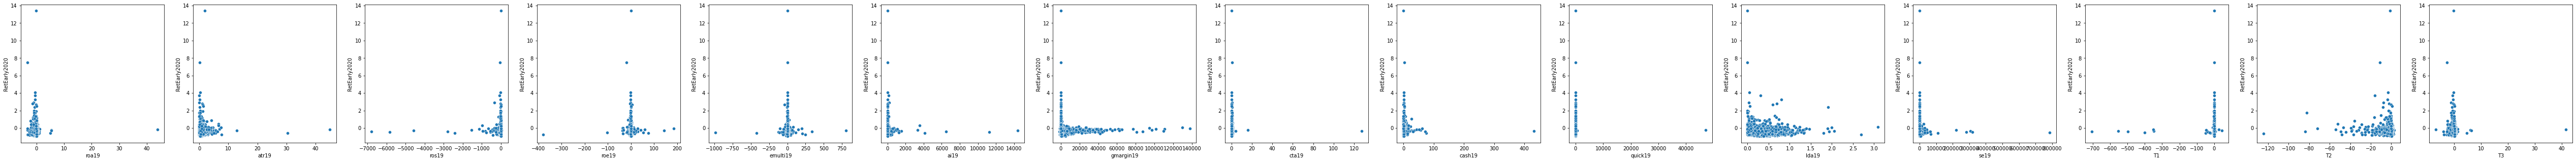

In [99]:
fig, axs = plt.subplots(1, 15, figsize=(90, 5))
for i, v in enumerate(ratios):
    sns.scatterplot(data=df, x=v, y='RetEarly2020', ax=axs[i])

In [100]:
# remove outliers for each ratio
print(df.shape)
df = df[~(df.roa19>10)]
df = df[~(df.atr19>10)]
df = df[~(df.ros19<-2000)]
df = df[~(abs(df.roe19)>100)]
df = df[~(abs(df.emulti19)>250)]
df = df[~(df.ai19>2000)]
df = df[~(df.gmargin19>80000)]
df = df[~(df.cta19>10)]
df = df[~(df.cash19>100)]
df = df[~(df.quick19>10000)]
df = df[~(df.lda19>2.5)]
df = df[~(df.se19>100000)]
df = df[~(df.T1<-100)]
df = df[~(df.T2<-60)]
df = df[~(df.T3>10)]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(4130, 54)
(4085, 54)


Winsorize each ratio at 3% and 97% values.

In [101]:
for i in ratios:
    df[i] = pd.Series(winsorize(df[i], limits=[0.03, 0.03]))

Replace missing ratios with the average of the GICS industry group a stock belongs to.

In [102]:
# examine missing values
pd.DataFrame({'Number of companies with NA':(df[ratios].isna().sum()).sort_values(ascending=False)}).T

,quick19,se19,T3,T2,T1,lda19,cash19,cta19,gmargin19,ai19,emulti19,roe19,ros19,atr19,roa19
Number of companies with NA,419,153,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
# check if there's any industry group without any quick19 or se19
print(df.groupby('ggroup').quick19.count().sort_values()[:2])
print(df.groupby('ggroup').se19.count().sort_values()[:2])

ggroup
Banks                       14
Food & Staples Retailing    26
Name: quick19, dtype: int64
ggroup
Food & Staples Retailing         26
Household & Personal Products    36
Name: se19, dtype: int64


In [104]:
# replace missing ratios with GICS industry group average
qmeans = df.groupby('ggroup').quick19.mean()
smeans = df.groupby('ggroup').se19.mean()
df['quick19'] = np.where(df['quick19'].isna(), qmeans[df['ggroup']], df['quick19'])
df['se19'] = np.where(df['se19'].isna(), smeans[df['ggroup']], df['se19'])

In [105]:
# double check that there's no missing value anymore
pd.DataFrame({'Number of companies with NA':(df[ratios].isna().sum())}).T

,roa19,atr19,ros19,roe19,emulti19,ai19,gmargin19,cta19,cash19,quick19,lda19,se19,T1,T2,T3
Number of companies with NA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
# # export into a csv file
# df.to_csv('df_ratios_cleaned.csv', index=False)

## Single-Variable Regressions
We will first examine the explanatory power of the single regression models built on different financial ratios.


In [107]:
df = pd.read_csv('df_ratios_cleaned.csv')

In [108]:
cols = ['ticker', 'RetEarly2020', 'RetLate2020']
cols.extend(ratios)
df2 = df.dropna(subset=ratios)[cols].copy()
df2['intercept'] = 1

In [109]:
# regress RetEarly2020 on every ratio
Y = df2['RetEarly2020']
for i in ratios:
    X = df2[['intercept', i]]
    print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     58.73
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           2.24e-14
Time:                        23:02:14   Log-Likelihood:                -1895.0
No. Observations:                4085   AIC:                             3794.
Df Residuals:                    4083   BIC:                             3807.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3089      0.006    -50.145      0.0

In [110]:
# regress RetEarly2020 on every ratio's reciprocal
Y = df2['RetEarly2020']
for i in ratios:
    if (i=='lda19') or (i=='T1') or (i=='T2'):
        tmp = df2[df2[i]!=0]
        Y2 = tmp['RetEarly2020']
        X = 1/tmp[['intercept', i]]
        print(sm.OLS(Y2, X).fit().summary())
    else:
        X = 1/df2[['intercept', i]]
        print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.07133
Date:                Mon, 05 Jul 2021   Prob (F-statistic):              0.789
Time:                        23:02:15   Log-Likelihood:                -1924.1
No. Observations:                4085   AIC:                             3852.
Df Residuals:                    4083   BIC:                             3865.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2989      0.006    -49.240      0.0

In [111]:
# regress RetLate2020 on every ratio
Y = df2['RetLate2020']
for i in ratios:
    X = df2[['intercept', i]]
    print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     95.43
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           2.69e-22
Time:                        23:02:15   Log-Likelihood:                -7443.7
No. Observations:                4085   AIC:                         1.489e+04
Df Residuals:                    4083   BIC:                         1.490e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8550      0.024     35.685      0.0

In [112]:
# regress RetLate2020 on every ratio's reciprocal
Y = df2['RetLate2020']
for i in ratios:
    if (i=='lda19') or (i=='T1') or (i=='T2'):
        tmp = df2[df2[i]!=0]
        Y2 = tmp['RetEarly2020']
        X = 1/tmp[['intercept', i]]
        print(sm.OLS(Y2, X).fit().summary())
    else:
        X = 1/df2[['intercept', i]]
        print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1085
Date:                Mon, 05 Jul 2021   Prob (F-statistic):              0.742
Time:                        23:02:15   Log-Likelihood:                -7490.8
No. Observations:                4085   AIC:                         1.499e+04
Df Residuals:                    4083   BIC:                         1.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9046      0.024     38.144      0.0

## Multi-Variable Regressions
Then, we try out different combinations of financial ratios to explain the variation in 2020 stock returns using multiple regression.

In [113]:
# regress RetEarly2020 on all ratios
Y = df2['RetEarly2020']
X = pd.concat([df2['intercept'], df2[ratios]], axis=1)
print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     11.91
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           2.33e-29
Time:                        23:02:15   Log-Likelihood:                -1836.4
No. Observations:                4085   AIC:                             3705.
Df Residuals:                    4069   BIC:                             3806.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2663      0.020    -13.335      0.0

In [114]:
# regress RetEarly2020 on significant ratios with higher R2 (>0.01)
Y = df2['RetEarly2020']
X = pd.concat([df2[['intercept', 'roa19', 'ros19', 'cta19', 'cash19', 'lda19', 'se19', 'T1', 'T2', 'T3']], 
               1/df2[['se19']]], axis=1)
print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     16.74
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           4.46e-30
Time:                        23:02:15   Log-Likelihood:                -1841.9
No. Observations:                4085   AIC:                             3706.
Df Residuals:                    4074   BIC:                             3775.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2864      0.013    -22.550      0.0

In [115]:
# regress RetEarly2020 on suggested ratios
Y = df2['RetEarly2020']
X = pd.concat([df2[['intercept', 'cta19', 'cash19', 'lda19']], 
               1/df2[['quick19', 'se19']]], axis=1)
print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     26.74
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           1.09e-26
Time:                        23:02:15   Log-Likelihood:                -1858.3
No. Observations:                4085   AIC:                             3729.
Df Residuals:                    4079   BIC:                             3766.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3170      0.014    -23.211      0.0

In [116]:
# regress RetLate2020 on all ratios
Y = df2['RetLate2020']
X = pd.concat([df2['intercept'], df2[ratios]], axis=1)
print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     19.02
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           4.85e-50
Time:                        23:02:15   Log-Likelihood:                -7352.4
No. Observations:                4085   AIC:                         1.474e+04
Df Residuals:                    4069   BIC:                         1.484e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7400      0.077      9.605      0.0

In [117]:
# regress RetLate2020 on significant ratios with higher R2 (>0.01)
Y = df2['RetLate2020']
X = pd.concat([df2[['intercept', 'roa19', 'atr19', 'roe19', 'T2', 'T3']], 
               1/df2['ai19']], axis=1)
print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     35.63
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           3.03e-42
Time:                        23:02:15   Log-Likelihood:                -7386.5
No. Observations:                4085   AIC:                         1.479e+04
Df Residuals:                    4078   BIC:                         1.483e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5857      0.037     15.826      0.0

In [118]:
# regress RetLate2020 on suggested ratios
Y = df2['RetLate2020']
X = pd.concat([df2[['intercept', 'cta19', 'lda19']], 
               1/df2[['cash19', 'quick19', 'se19']]], axis=1)
print(sm.OLS(Y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     12.96
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           1.55e-12
Time:                        23:02:15   Log-Likelihood:                -7458.7
No. Observations:                4085   AIC:                         1.493e+04
Df Residuals:                    4079   BIC:                         1.497e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5903      0.058     10.164      0.0

## Interpretation

We will particularly focus on the `Cash/Total Assets`, `Cash/Current Liabilities`, `Quick`, `Long-Term Debt/Total Assets`, and `Net Sales/Number of Employees` ratios as suggested.

Looking at each ratio's single regression models, we can conclude that:
* `Cash/Total Assets` ratio can explain around 2% of the variation in `RetEarly2020` and 0.1% of the variation in `RetLate2020`. Firms with more cash at the end of 2019 have higher 3-month and 9-month returns in 2020.
* `Cash/Current Liabilities` ratio can explain 1% of the variation in `RetEarly2020` and the inverse of `Cash/Current Liabilities` can explain 0.1% of the variation in `RetLate2020`. Firms with more cash to cover current liabilities at the end of 2019 have higher 3-month and 9-month returns in 2020.
* The inverse of `Quick` ratio can explain 0.2% of the variation in `RetEarly2020` and 0.6% of the variation in `RetLate2020`. Firms with more liquid assets to cover current liabilities at the end of 2019 have higher 3-month return in early 2020 and lower 9-month return later.
* `Long-Term Debt/Total Assets` ratio can explain 1.3% of the variation in `RetEarly2020` and 0.2% of the variation in `RetLate2020`. Firms with lower long-term debt at the end of 2019 have higher 3-month return in early 2020 and lower 9-month return later.
* The inverse of `Sales per Employees` ratio can explain 1.2% of the variation in `RetEarly2020` and 0.3% of the variation in `RetLate2020`. Firms that have higher reliance on labor perform better in 2020.

When we use all of the suggested ratios to build multi-variable regression models, our models can explain 3.1% of the variation in `RetEarly2020` and 1.4% of the variation in `RetLate2020`. Whether this explanatory power is high or low depends on what we compare these regression models with. Intuitively, models that can only explains 3.1% or 1.4% of the variation seems to have a very low explanatory power. However, if we compare these amounts with the single regression models, it seems that we now have a little higher explanatory power. Additionally, if we add 10 more financial ratios, our models would be able to explain up to around 4% and 6.2% of the variation in `RetEarly2020` and `RetLate2020`. According to these multi-variable regressions, we see that in 2020, firms with more cash (to cover current liabilities), less liquid assets, higher long-term debt, and higher reliance on labor on average have higher 3-month and 9-month returns. This is consistent with our earlier industry-fixed effect regression results.

# 3. Explaining Fluctuation Using Market Betas

**Do pre-COVID risk measures (i.e., in 2019) explain variation in stock returns for early and late 2020?**

In [119]:
df = pd.read_csv('maindf.csv')

`RetEarly2020` and `RetLate2020` are the variables whose variation is what we're trying to explain.

The pre-COVID risk measure we chose is the market beta of each stock in 2019 (downloaded from WRDS CRSP).

In [120]:
# examine missing values
df['beta19'].isna().sum()

92

There are 92 stocks with missing market beta. We will replace a stock's missing beta with the average beta of the GICS industry it belongs to.

In [121]:
# check if there's any industry without any market beta
df.groupby('gind').beta19.count().sort_values()

gind
Transportation Infrastructure                     6
Tobacco                                           7
Industrial Conglomerates                          8
Distributors                                      9
Multiline Retail                                 10
                                               ... 
Equity Real Estate Investment Trusts (REITs)    173
Software                                        179
Oil, Gas & Consumable Fuels                     212
Biotechnology                                   261
Banks                                           325
Name: beta19, Length: 69, dtype: int64

In [122]:
# replace missing betas with industry average
means = df.groupby('sic').beta19.mean()
df['beta19'] = np.where(df['beta19'].isna(), means[df['sic']], df['beta19'])

In [123]:
# double check that there's no missing value anymore
df['beta19'].isna().sum()

0

In [124]:
# # export into a csv file
# df.to_csv('df_beta.csv', index=False)

Regress `RetEarly2020` and `RetLate2020` on `beta19` respectively.

In [125]:
# regress RetEarly2020 on beta19
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020', 'beta19']].copy()
df2['intercept'] = 1
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     22.74
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           1.91e-06
Time:                        23:02:47   Log-Likelihood:                -1932.7
No. Observations:                4130   AIC:                             3869.
Df Residuals:                    4128   BIC:                             3882.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
beta19        -0.0398      0.008     -4.769      0.0

In [126]:
# regress RetLate2020 on beta19
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8684
Date:                Mon, 05 Jul 2021   Prob (F-statistic):              0.351
Time:                        23:02:47   Log-Likelihood:                -7746.9
No. Observations:                4130   AIC:                         1.550e+04
Df Residuals:                    4128   BIC:                         1.551e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
beta19         0.0318      0.034      0.932      0.3

## Interpretation

Market beta represents the sensitivity of the stock to the movement of the market. When we regress `RetEarly2020` on the 2019 market beta, the intercept suggests that for stocks completely free of systematic risk, the average 3-month return is -0.26. The coefficient of the market beta is -0.04. It means that for stocks that are as volatile as the market (β=1), the average 3-month return is -0.3. The more sensitive a stock is to the market's swing (larger β), the lower its 3-month return in early 2020. It's worth noting that the $R^2$ and adjusted $R^2$ of this regression model is 0.005, meaning it has little explanatory power. It can only explain 0.5% of the variation in `RetEarly2020`.


When we regress `RetLate2020` on the 2019 market beta, the intercept suggests that for stocks completely free of systematic risk, the average 9-month return is 0.88. The coefficient of the market beta is 0.03. However, its *p*-value is greater than 0.05, meaning this coefficient is not significantly different from 0. Therefore, we would say that the 2019 market beta has no effect on stocks' 9-month return in 2020. Indeed, we also see that the $R^2$ and adjusted $R^2$ of this regression model is 0, meaning it has no explanatory power.

# 4. Explaining Fluctuation Using Historical Volatility

**Does the volatility in 2019 stock returns explain variation in stock returns for early and late 2020?**

In [127]:
df = pd.read_csv('df_beta.csv')

## Preprocessing Stock Data from 2019

`stock19.csv` contains the stock data for all the U.S. companies in WRDS CRSP database.
* `date` is the date of the last trading day of each month in 2019.
* `ticker` is the ticker for each stock.
* `price` is the closing price on the last trading day in each month in 2019.
* `ret` is the holding period (monthly) return for each stock.

In [128]:
stock19 = pd.read_csv('stock19.csv')

In [129]:
# clean up the columns
stock19.rename(columns={'TICKER': 'ticker', 'PRC': 'price', 'RET': 'ret'}, inplace=True)
stock19.date = pd.to_datetime(stock19.date, format="%Y%m%d")
stock19['month'] = pd.DatetimeIndex(stock19.date).month

In [130]:
# drop stocks that are not in the main dataframe
stock19 = stock19[stock19.ticker.isin(df.ticker)]
stock19.reset_index(drop=True, inplace=True)

There are 13 companies that have two sets (24) of monthly returns.


In [131]:
tmp = stock19.ticker.value_counts()
tmp[tmp.index[tmp.gt(12)]]

TAP     24
GEF     24
HVT     24
LEN     24
WSO     24
MKC     24
BIO     24
BH      24
STZ     24
AGM     24
CWEN    24
HEI     24
GTN     23
Name: ticker, dtype: int64

Cross examine two sets of stock prices from CRSP with those listed on Yahoo Finance and only keep the ones that match.

In [132]:
tics = " ".join(tmp.index[tmp.gt(12)].to_list())
df_yahoo = yf.download(tics, start="2018-12-31", end="2020-01-01", group_by='ticker')
dates = ['2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30', '2019-05-31', '2019-06-28', 
         '2019-07-31', '2019-08-30', '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31']

for i in tmp.index[tmp.gt(12)]:
    if df_yahoo[i].dropna().empty:
        continue
    else:
        try:
            prices = round(df_yahoo[i].loc[dates, 'Close'], 2).to_list()
            stock19.loc[stock19.ticker==i, 'price'] = stock19[stock19.ticker==i]['price'].apply(lambda x: x if round(x, 2) in prices else np.nan)
            stock19.dropna(subset=['price'], inplace=True)
            stock19.reset_index(drop=True, inplace=True)
        except:
            pass

[*********************100%***********************]  13 of 13 completed


In [133]:
# make sure there's no stock with more than 12 monthly returns
tmp = stock19.ticker.value_counts()
len(tmp.index[tmp.gt(12)])

0

## Linear Regression Models

Now, we will determine if the standard deviation of a stock's monthly returns in 2019 can help explain the variation in its returns in 2020.

In [134]:
# calculate standard deviation of each stock's 2019 monthly returns
std = pd.DataFrame(stock19.groupby('ticker').ret.std().reset_index())
std.rename(columns={'ret': 'std'}, inplace=True)
std.head(2)

,ticker,std
0,A,0.077494
1,AA,0.109564


In [135]:
# drop missing standard deviation
std.dropna(subset=['std'], inplace=True)

In [136]:
# # export into a csv file
# std.to_csv('std.csv', index=False)

In [137]:
# only keep the stocks that have data from 2019
df2 = df[['ticker', 'RetEarly2020', 'RetLate2020']].copy()
df2 = df2[df2.ticker.isin(std.ticker)]
df2 = df2.merge(std, on='ticker')
df2.reset_index(drop=True, inplace=True)
print("Number of unique tickers:", df2.ticker.nunique())

Number of unique tickers: 4096


In [138]:
# regress RetEarly2020 on standard deviation
df2['intercept'] = 1
Y = df2['RetEarly2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg1 = sm.OLS(Y, X).fit()
print(reg1.summary())

                            OLS Regression Results                            
Dep. Variable:           RetEarly2020   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8766
Date:                Mon, 05 Jul 2021   Prob (F-statistic):              0.349
Time:                        23:03:16   Log-Likelihood:                -1928.0
No. Observations:                4096   AIC:                             3860.
Df Residuals:                    4094   BIC:                             3873.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
std            0.0431      0.046      0.936      0.3

In [139]:
# regress RetLate2020 on standard deviation
Y = df2['RetLate2020']
X = df2.drop(columns=['ticker', 'RetEarly2020', 'RetLate2020'])
reg2 = sm.OLS(Y, X).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:            RetLate2020   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     110.3
Date:                Mon, 05 Jul 2021   Prob (F-statistic):           1.73e-25
Time:                        23:03:16   Log-Likelihood:                -7612.6
No. Observations:                4096   AIC:                         1.523e+04
Df Residuals:                    4094   BIC:                         1.524e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
std            1.9352      0.184     10.505      0.0

## Interpretation

The standard deviation of stock returns is another measure of risk. When we regress `RetEarly2020` on the standard deviation of 2019 monthly returns, the intercept suggests that for stocks with no variability in returns, the average 3-month return is -0.30. The coefficient of the standard deviation is 0.04. However, its *p*-value is greater than 0.05, meaning this coefficient is not significantly different from 0. Therefore, we would say that the volatility of 2019 returns has no effect on stocks' 3-month return in early 2020. Indeed, we also see that the $R^2$ and adjusted $R^2$ of this regression model is 0, meaning it has no explanatory power.

When we regress `RetLate2020` on the standard deviation of 2019 monthly returns, the intercept suggests that stocks with no variability in returns, the average 9-month return is 0.66. The coefficient of the market beta is 1.94. It means that the more volatile a stock in 2019 (large standard deviation), the higher its 9-month return in 2020. The $R^2$ and adjusted $R^2$ of this regression model is 0.03, meaning it does have a little explanatory power and that it can explain around 3% of the variation in `RetLate2020`.

# 5. Predicting Returns Using DistilBERT Model and Business Descriptions



We are missing the business descriptions for 1565 companies.

In [140]:
df = pd.read_csv('df_beta.csv')

In [141]:
# a list of companies without business description
noDes = df.loc[df.description.isna(), 'ticker'].unique()
len(noDes)

1565

Scrape the business descriptions from Yahoo Finance for these companies.

In [ ]:
# # WARNING!! - Don't run this loop. The results are already saved in "missing_des.csv"

# DES = []
# tickers = noDes
# for i in tickers:
#   url ='https://finance.yahoo.com/quote/'+i+'/profile' 
#   page = requests.get(url)
#   htmldata = BeautifulSoup(page.content, 'html.parser')
#   Business_Description = htmldata.find('p', {'class':'Mt(15px) Lh(1.6)'})
#   DES.append(Business_Description)

In [ ]:
# # create new dataframe that stores tickers and their corresponding descriptions
# company_des = pd.DataFrame({'ticker':tickers, 'description':DES})

# # drop the stocks that do not have Yahoo Finance company profiles
# company_des.dropna(inplace=True)
# company_des['description'] = company_des['description'].astype(str)

In [ ]:
# # remove regex text from description
# a = np.arange(1,300)
# a = a.astype(str)
# for i in a:
#   company_des['description']=company_des['description'].str.replace('<p class="Mt(15px) Lh(1.6)" data-reactid="'+i+'">','',regex=False)

# company_des['description']=company_des['description'].str.replace('</p>','',regex=False)

In [ ]:
# # export company_des into a CSV file
# company_des.to_csv('missing_des.csv', index=False)

Insert the missing descriptions into the main dataframe.

In [142]:
# load the newly scraped business descriptions
company_des = pd.read_csv('missing_des.csv')
company_des.head(2)

,ticker,description
0,AACG,"ATA Creativity Global, together with its subsi..."
1,AAMC,"Altisource Asset Management Corporation, an as..."


In [143]:
# insert the newly scraped business descriptions into the main dataframe
tmp = df[['ticker', 'description']]
tmp = tmp.merge(company_des, on='ticker', how='outer')
tmp.description_x = np.where(tmp['description_x'].isna(), tmp['description_y'], tmp['description_x'])
df['description'] = tmp['description_x']

Drop 86 companies that still do not have without business descriptions.

In [144]:
# how many companies still don't have their business descriptions?
print(df.shape)
df = df[~df.description.isna()]
print(df.shape)

(4130, 42)
(4044, 42)


In [145]:
# # export into a csv file
# df.to_csv('df_des.csv', index=False)

Load a pre-trained distilBERT model.

In [146]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Due to Colab's RAM limitations, limit the description size to 350 characters.

In [147]:
df['description'] = df['description'].str.slice(0, 350)

Tokenize the business descriptions for BERT and pad all lists of tokenized values to the same size. 

In [148]:
tokenized = df['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

max_len = max(map(len, tokenized.values))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
padded.shape

(4044, 113)

Create attention mask variable for DistilBERT to ignore the padding when it's processing its input.

In [149]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(4044, 113)

Run the pretrained DistilBERT model on the prepared predictor, save the result in `last_hidden_states`, and keep the first layer of the hidden states in `features`.

In [ ]:
# # WARNING!! - Don't run the DistilBERT model. The results are already saved in "features.npy"
# input_ids = torch.tensor(padded)
# attention_mask = torch.tensor(attention_mask)

# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

# features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
# # save features into a npy file
# np.save('features', features)

## Predicting Stock Returns Using Business Descriptions

In [150]:
features = np.load('features.npy')

Create binary labels for `RetEarly2020` and `RetLate2020`.
* `BetterEarly2020` is 1, if a stock's `RetEarly2020` is in the top 35% (i.e., higher than 65% of the companies); otherwise, 0.
* `BetterLate2020` is 1, if a stock's `RetLate2020` is in the top 35% (i.e., higher than 65% of the companies); otherwise, 0.

In [151]:
df['BetterEarly2020'] = 0
df['BetterLate2020'] = 0
df['BetterEarly2020'] = np.where(df.RetEarly2020>=df.RetEarly2020.quantile(0.65), 1, 0)
df['BetterLate2020'] = np.where(df.RetLate2020>=df.RetLate2020.quantile(0.65), 1, 0)

1416 stocks are labeled as performing better than most in early 2020 and late 2020 respectively.

In [152]:
print(df.BetterEarly2020.value_counts())
print(df.BetterLate2020.value_counts())

0    2628
1    1416
Name: BetterEarly2020, dtype: int64
0    2628
1    1416
Name: BetterLate2020, dtype: int64


### Logistic Regression Model for `BetterEarly2020`

Split the data into training and test sets (`random_state=870`).

Train the logistic regression models on the training set (75%) and evaluate its accuracy on the test set (25%).

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# logistic regression for BetterEarly2020
X_train, X_test, Y_train, Y_test = train_test_split(features, df['BetterEarly2020'], test_size=0.25, random_state=870)
log = LogisticRegression(max_iter=5000)
log.fit(X_train, Y_train) 
print(log.score(X_test, Y_test))

0.712166172106825


In predicting `BetterEarly2020` for the test set, our model has an accuracy score of **0.71**. 

Check if this approach works better than a random guess.

In [154]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# accuracy of a random guess
clf = DummyClassifier()
scores = cross_val_score(clf, X_train, Y_train)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Dummy classifier score: 0.526 (+/- 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Create a confusion matrix.

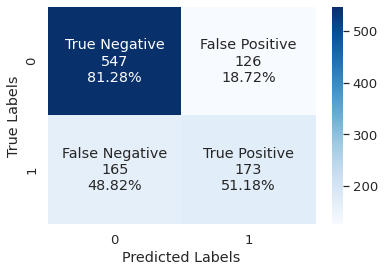

In [155]:
predictions = log.predict(X_test)
matrix = confusion_matrix(Y_test, predictions)

sns.set(font_scale=1.2)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in np.array([row/np.sum(row) for row in matrix]).flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

### Logistic Regression Model for `BetterLate2020`

In [156]:
# logistic regression for BetterLate2020
X_train, X_test, Y_train, Y_test = train_test_split(features, df['BetterLate2020'], test_size=0.25, random_state=870)
log2 = LogisticRegression(max_iter=5000)
log2.fit(X_train, Y_train)
print(log2.score(X_test, Y_test))

0.6805143422354105


In predicting `BetterLate2020` for the test set, our model has an accuracy score of **0.68**. 

In [157]:
# accuracy of a random guess
clf = DummyClassifier()
scores = cross_val_score(clf, X_train, Y_train)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Dummy classifier score: 0.553 (+/- 0.04)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Create a confusion matrix.

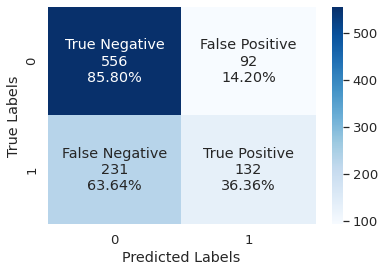

In [158]:
predictions = log2.predict(X_test)
matrix = confusion_matrix(Y_test, predictions)

sns.set(font_scale=1.2)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in np.array([row/np.sum(row) for row in matrix]).flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

## Interpretation

The logistic regressions built on the output of DistilBERT model have a decent amount of power (better than random guesses) in predicting whether a stock performed better than most in 2020. Given the business description of a company, our models are able to predict whether its 3-month and 9-month returns in 2020 are higher than 65% of the stocks. The models have an accuracy of 0.71 in predicting stock performance in early 2020 and an accuracy of 0.68 in predicting stock performance in late 2020. However, one limitation is that we could not easily tell which types of business description lead to better stock performance and which types do not.

# 6. Putting Everything Together

In [159]:
df_cleaned = pd.read_csv('df_beta.csv')
df_ratios = pd.read_csv('df_ratios_cleaned.csv')
std = pd.read_csv('std.csv')
df_des = pd.read_csv('df_des.csv')
features = pd.DataFrame(np.load('features.npy'))

In [160]:
# merge dataframes into one
print(df_cleaned.shape)
cols = ['ticker']
cols.extend(list(df_ratios.columns[42:]))
df = df_cleaned.merge(df_ratios[cols], on='ticker')
df = df.merge(std, on='ticker')
df_des = pd.concat([df_des['ticker'], features], axis=1)
df = df.merge(df_des, on='ticker')
print(df.shape)

(4130, 42)
(3967, 823)


In [161]:
df.head(1)

,ticker,RetEarly2020,RetLate2020,SPEarly2020,SPLate2020,beta19,gsector,ggroup,gind,gsubind,naics,nsector,sic,sgroup,spcsrc,description,at18,at19,act19,invt19,lt19,lct19,ap19,teq18,teq19,re19,sale19,cogs19,xopr19,ni19,oancf19,ivncf19,fincf19,avgat19,avgteq19,roa19,atr19,ros19,roe19,emulti19,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,JJSF,-0.340234,0.30034,-0.20001,0.453255,0.01282,Consumer Staples,"Food, Beverage & Tobacco",Food Products,30202030,311812.0,Manufacturing,2050.0,Manufacturing,A-,"J &amp; J Snack Foods Corp. manufactures, mark...",932.013,1019.339,506.357,116.165,185.588,121.234,72.029,759.091,833.751,788.007,1186.487,787.541,1020.986,94.819,147.499,-43.363,-22.826,975.676,796.421,0.097183,1.216067,0.079916,0.119056,1.225076,...,0.30228,-0.060534,-0.039758,0.098368,-0.177747,-0.102328,0.358698,-0.226192,-0.390968,0.187713,-0.216292,-0.029709,0.047325,0.172805,-0.155044,-0.202284,0.288933,0.352452,0.292123,-0.008322,-0.188712,-0.030823,-0.129796,0.094278,-4.908693,-0.339355,-0.286043,-0.098626,-0.235689,-0.236586,-0.073754,-0.342572,0.080311,-0.012324,0.336364,-0.012803,0.202466,0.168136,0.368592,0.300237


## Linear Regression Models

`df` is our final dataframe that has 3967 stocks with all kinds of data.

In [162]:
# create industry indicators
df2 = df['ggroup'].copy()
df2 = pd.get_dummies(df2, columns=['ggroup'], prefix='', prefix_sep='')
df2.head(1)

,Automobiles & Components,Banks,Capital Goods,Commercial & Professional Services,Communication Services,Consumer Durables & Apparel,Consumer Services,Diversified Financials,Energy,Food & Staples Retailing,"Food, Beverage & Tobacco",Health Care Equipment & Services,Household & Personal Products,Insurance,Materials,Media & Entertainment,"Pharmaceuticals, Biotechnology & Life Sciences",Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Technology Hardware & Equipment,Transportation,Utilities
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [163]:
# a list of 15 financial ratios
print(ratios)

['roa19', 'atr19', 'ros19', 'roe19', 'emulti19', 'ai19', 'gmargin19', 'cta19', 'cash19', 'quick19', 'lda19', 'se19', 'T1', 'T2', 'T3']


In [164]:
# add a constant
df['intercept'] = 1

Now that we have a well-set-up dataframe, we can put all the explanatory variables we've inspected together and see if we can better explain the variation in `RetEarly2020` and `RetLate2020`.

In [165]:
# explain variation in RetEarly2020
Y = df['RetEarly2020']
X = pd.concat([
               df2, # industry indicators
            #    df['intercept'],
            #    df[ratios],
            #    df[['roa19', 'lda19', 'roe19']],
            #    df.se19,
            #    df['beta19'],
            #    df['std'],
               df[df.columns[-769:-1]] # business descriptions
               ], axis=1)
reg = sm.OLS(Y, X).fit()
print('R-squared:', round(reg.rsquared, 3))
print('Adj. R-squared:', round(reg.rsquared_adj, 3))

R-squared: 0.552
Adj. R-squared: 0.44


In [166]:
# explain variation in RetLate2020
Y = df['RetLate2020']
X = pd.concat([
               df2, # industry indicators
            #    df['intercept'],
            #    df[ratios],
            #    df[['roa19', 'lda19', 'roe19']],
            #    df.se19,
            #    df['beta19'],
            #    df['std'],
               df[df.columns[-769:-1]] # business descriptions
               ], axis=1)
reg = sm.OLS(Y, X).fit()
print('R-squared:', round(reg.rsquared, 3))
print('Adj. R-squared:', round(reg.rsquared_adj, 3))
# print(pd.DataFrame(reg.params[:-769])], columns=['coefficient']))

R-squared: 0.519
Adj. R-squared: 0.399


As it turns out, the models with the highest explanatory power ($R^2$ and adjusted $R^2$) are the ones built with GICS industry group indicators and business descriptions. 44% of the variation in `RetEarly2020` and about 40% of the variation in `RetLate2020` can be explained by these models. Including financial ratios and risk measures in the models does not significantly improve their explanatory power.

## Logistic Regression Models

We can again try to predict whether a stock performed better than others in 2020, using all the explanatory variables at hand.
* `BetterEarly2020` is 1, if a stock's `RetEarly2020` is in the top 35% (i.e., higher than 65% of the companies); otherwise, 0.
* `BetterLate2020` is 1, if a stock's `RetLate2020` is in the top 35% (i.e., higher than 65% of the companies); otherwise, 0.

In [167]:
df['BetterEarly2020'] = 0
df['BetterLate2020'] = 0
df['BetterEarly2020'] = np.where(df.RetEarly2020>=df.RetEarly2020.quantile(0.65), 1, 0)
df['BetterLate2020'] = np.where(df.RetLate2020>=df.RetLate2020.quantile(0.65), 1, 0)

In [168]:
print(df.BetterEarly2020.value_counts())
print(df.BetterLate2020.value_counts())

0    2578
1    1389
Name: BetterEarly2020, dtype: int64
0    2578
1    1389
Name: BetterLate2020, dtype: int64


Accuracy: 0.6975806451612904


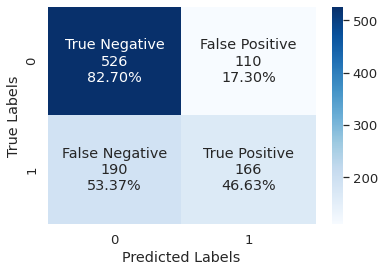

In [169]:
# predicting BetterEarly2020
Y = df['BetterEarly2020']
X = pd.concat([
               df2, # industry indicators
               df[ratios],
               df['beta19'],
               df['std'],
               df[df.columns[-771:-3]] # business descriptions
               ], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=870)
log = LogisticRegression(max_iter=100000)
log.fit(X_train, Y_train) 
print('Accuracy:', log.score(X_test, Y_test))

predictions = log.predict(X_test)
matrix = confusion_matrix(Y_test, predictions)
sns.set(font_scale=1.2)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in np.array([row/np.sum(row) for row in matrix]).flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

In [170]:
# accuracy of a random guess
clf = DummyClassifier()
scores = cross_val_score(clf, X_train, Y_train)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Dummy classifier score: 0.566 (+/- 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Accuracy: 0.7066532258064516


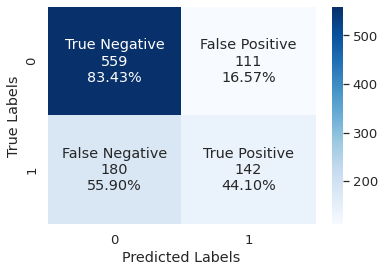

In [172]:
# logistic regression for BetterLate2020
Y = df['BetterLate2020']
X = pd.concat([
               df2, # industry indicators
               df[ratios],
               df['beta19'],
               df['std'],
               df[df.columns[-771:-3]] # business descriptions
               ], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=870)
log2 = LogisticRegression(max_iter=20000)
log2.fit(X_train, Y_train)
print('Accuracy:', log2.score(X_test, Y_test))

predictions = log2.predict(X_test)
matrix = confusion_matrix(Y_test, predictions)
sns.set(font_scale=1.2)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in np.array([row/np.sum(row) for row in matrix]).flatten()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

In [173]:
# accuracy of a random guess
clf = DummyClassifier()
scores = cross_val_score(clf, X_train, Y_train)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Dummy classifier score: 0.552 (+/- 0.03)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


This time, we used all variables availabe in the logistic regression models - 24 GICS industry group indicators, 15 financial ratios, 2019 market betas, 2019 return standard deviations, and business descriptions. Similar as before, including more variables does not significantly improve our prediction accuracy. Our models do a good job predicting whether a stock' 3-month and 9month returns in 2020 are higher than 65% of the stocks. The accuracy for predicting performance in early 2020 is 0.704 and the accuracy for predicting performance in late 2020 is 0.708.

# Conclusions

In industry-fixed regressions, we see that GICS codes have higher explanatory power than NAICS and SIC. To sum up, these are the industries that did the best and worst during the initial COVID shock and during market recovery.
* Least impacted by COVID shock: **Service** industry (especially **Health Care**)
* Most impacted by COVID shock: **Energy** industry (due to decline in transporation demand)
* Strongest rebound: **Automobiles & Retail** industries
* Slowest recovery: **Utilities** industry (historically relatively stable market)

Standing at the end of 2019, we observe that companies with the following characteristics tend to perform better in 2020.
* Have more cash (to cover current liabilities) at the end of 2019
* Have higher long-term debt to assets ratio at the end of 2019
* Have Higher reliance on labor at the end of 2019

In particular, stocks that have higher 3-month return are on average less sensitive to market swings. (They have lower 2019 market betas.) Stocks that have higher 9-month return are on average more volatile. (The standard deviations of their 2019 returns are higher.)

Last but not least, it turns out that business descriptions and industry indicators alone provide a decent amount of explanatory power in explaining the market fluctuation and are useful for predicting stock performance level.
